In [44]:
import re
import csv
import random
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# fontpath = os.path.expanduser('~/Downloads/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 12,
#     'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [61]:
siamese_error_analysis_df = pd.read_csv('Analysis/PS_error_analysis.csv')
ss_setup_error_analysis_df = pd.read_csv('Analysis/SS_error_analysis.csv')

In [10]:
def measure_ss_BERT_performance(df):
#     results = []
    results = [float(x == 'funny') for x in df['predicted_headline_original']]
    results.extend([float(x == 'serious') for x in df['predicted_headline_unfunned']])
    return np.sum(results) / len(results)

def measure_ss_GPT_performance(df, gpt_threshold=1e-19):
    if gpt_threshold is None:
        gpt_threshold = (np.mean(df['serious_prob']) + np.mean(df['funny_prob'])) / 2
#     results = []
    results = [float(x <= gpt_threshold) for x in df['funny_prob']]
    results.extend([float(x >= gpt_threshold) for x in df['serious_prob']])
    return np.sum(results) / len(results)

## Performance broken down by funny / serious

In [13]:
def get_probability_percentage(df, f):
    df['prob'] = df['funny_prob'] + df['serious_prob']
    M = list(df['prob']).copy()
    val = sorted(M)[int(f*len(M))]
    return df[df['prob'] <= val]

In [14]:
def serious_prob_vs_likelihood_score(test_df, percentages, bootstrap_resamples=10):
    x, diff = [], []
    for f in percentages:
        df_small = get_probability_percentage(test_df, f)
        for _ in range(bootstrap_resamples):
            df_small = df_small.sample(frac=1, replace=True)
            x.append(f)
            diff.append(np.log(1e-30 + np.mean(df_small['serious_prob'] - df_small['funny_prob'])))
#             funny.append(np.log(np.mean(df_small['serious_prob']))np.log(np.mean(df_small['funny_prob'])))
#             serious.append()
    res = pd.DataFrame.from_dict({'likelihood-score': x, 'diff': diff})
    return res

In [15]:
prob_vs_prob = serious_prob_vs_likelihood_score(ss_setup_error_analysis_df, [x / 10. for x in range(1, 8)])

<AxesSubplot:xlabel='likelihood-score'>

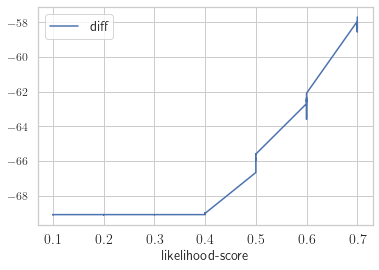

In [16]:
prob_vs_prob.plot(x='likelihood-score')

## Better performance when modification is bigger

In [17]:
def get_modification_of_size(df, n):
    def is_jaccard_below_f(row):
        a = set(row['headline_original'].split(' '))
        b = set(row['headline_unfunned'].split(' '))
        jaccard_distance = (1 - len(a.intersection(b)) / float(len(a.union(b))))
        return jaccard_distance <= n
    return df[df.apply(is_jaccard_below_f, axis=1)]

In [18]:
def performance_variation_with_mod_size_paired(test_df, sizes, bootstrap_resamples=100):
    x, siamese_bert, gpt2 = [], [], []
    for size in sizes:
        test_analysis_small = get_modification_of_size(test_df, size)
        for _ in range(bootstrap_resamples):
            test_small_resamples = test_analysis_small.sample(frac=1, replace=True)
            siamese_bert.append(np.sum(test_small_resamples['correct'])/ test_small_resamples.shape[0])
            gpt2.append(np.sum(test_small_resamples['GPT2-correct'])/ test_small_resamples.shape[0])
            x.append(size)
    res = pd.DataFrame.from_dict({'Modification-size (Jaccard)': x, 'Siamese-BERT': siamese_bert, 'GPT2': gpt2})
    return res

In [19]:
def performance_variation_with_mod_size_single(test_df, sizes, gpt_threshold=None, bootstrap_resamples=100):
    x, ss_bert, ss_gpt2 = [], [], []
    for size in sizes:
        test_analysis_small = get_modification_of_size(test_df, size)
        for _ in range(bootstrap_resamples):
            test_small_resamples = test_analysis_small.sample(frac=1, replace=True)
            ss_bert.append(measure_ss_BERT_performance(test_small_resamples))
            ss_gpt2.append(measure_ss_GPT_performance(test_small_resamples, gpt_threshold=None))
            x.append(size)
    res = pd.DataFrame.from_dict({'Modification-size (Jaccard)': x, 'SS-BERT': ss_bert, 'SS-GPT2': ss_gpt2})
    return res

In [20]:
fs = [x / 10. for x in range(1, 8)]
perf_size_ss = performance_variation_with_mod_size_single(ss_setup_error_analysis_df, fs)
perf_size_ps = performance_variation_with_mod_size_paired(siamese_error_analysis_df, fs)

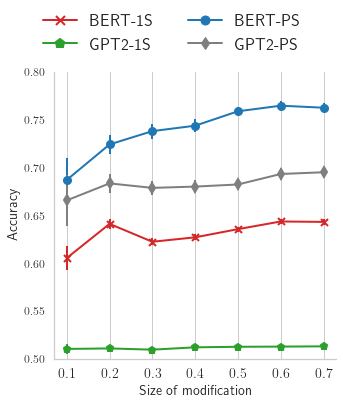

In [21]:
# sns.set_context('paper')
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)

x = perf_size_ss.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ss.groupby('Modification-size (Jaccard)').mean()['SS-BERT'].to_list()
yerr = 5*perf_size_ss.groupby('Modification-size (Jaccard)').sem()['SS-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')

x = perf_size_ss.groupby('Modification-size (Jaccard)').mean().index.to_list()
y_gpt = perf_size_ss.groupby('Modification-size (Jaccard)').mean()['SS-GPT2'].to_list()
y_gpt = [y_ + 0.007 for y_ in y_gpt]
yerr = 5*perf_size_ss.groupby('Modification-size (Jaccard)').sem()['SS-GPT2'].to_numpy()
ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:green')


x = perf_size_ps.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ps.groupby('Modification-size (Jaccard)').mean()['Siamese-BERT'].to_list()
yerr = 5*perf_size_ps.groupby('Modification-size (Jaccard)').sem()['Siamese-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:blue')

x = perf_size_ps.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ps.groupby('Modification-size (Jaccard)').mean()['GPT2'].to_list()
yerr = 5*perf_size_ps.groupby('Modification-size (Jaccard)').sem()['GPT2'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.5, 0.80)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks(x)
ax.set_yticks([l/100. for l in range(50, 85, 5)])

ax.set_xlabel('Size of modification')
ax.set_ylabel('Accuracy')

legend_elem = [
               Line2D([0], [0], marker='x', linewidth=2, ms=9, mew=2, c='tab:red', label='BERT-1S'),
               Line2D([0], [0], marker='p', linewidth=2, ms=9, mew=2, c='tab:green', label='GPT2-1S'),
               Line2D([0], [0], marker='o', linewidth=2, ms=9, c='tab:blue', label='BERT-PS'),
              Line2D([0], [0], marker='d', linewidth=2, ms=9, c='tab:gray', label='GPT2-PS')]

fig.legend(handles=legend_elem, ncol=2, loc='upper center', frameon=False, fontsize=17,  bbox_to_anchor=(0.5, 1.15))

fig.tight_layout(pad=1.1)
# fig.savefig("performance_size.pdf", bbox_inches="tight")

# fig.show()
# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='GPT2', ax=ax)
# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)
# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='GPT2', ax=ax)

## Better performance for higher prob

In [22]:
def performance_vs_prob_paired(test_df, percentages, bootstrap_resamples=100):
    x, siamese_bert, gpt2 = [], [], []
    for f in percentages:
        test_analysis_small = get_probability_percentage(test_df, f)
        for _ in range(bootstrap_resamples):
            test_small_resamples = test_analysis_small.sample(frac=1, replace=True)
            siamese_bert.append(np.sum(test_small_resamples['correct'])/ test_small_resamples.shape[0])
            gpt2.append(np.sum(test_small_resamples['GPT2-correct'])/ test_small_resamples.shape[0])
            x.append(f)
    return pd.DataFrame.from_dict({'Mean-prob': x, 'Siamese-BERT': siamese_bert, 'GPT2': gpt2})

In [23]:
def performance_vs_prob_single(test_df, percentages, bootstrap_resamples=100):
    x, ss_bert, ss_gpt2 = [], [], []
    for f in percentages:
        test_analysis_small = get_probability_percentage(test_df, f)
        for _ in range(bootstrap_resamples):
            test_small_resamples = test_analysis_small.sample(frac=1, replace=True)
            ss_bert.append(measure_ss_BERT_performance(test_small_resamples))
            ss_gpt2.append(measure_ss_GPT_performance(test_small_resamples, gpt_threshold=None))
            x.append(f)
    return pd.DataFrame.from_dict({'Mean-prob': x, 'SS-BERT': ss_bert, 'SS-GPT2': ss_gpt2})

In [24]:
siamese_with_prob = pd.concat([siamese_error_analysis_df, ss_setup_error_analysis_df[['funny_prob', 'serious_prob']]], axis=1)
percentages = [x / 10. for x in range(1, 10)]
perf_prob_ss = performance_vs_prob_single(ss_setup_error_analysis_df, percentages)
perf_prob_ps = performance_vs_prob_paired(siamese_with_prob, percentages)

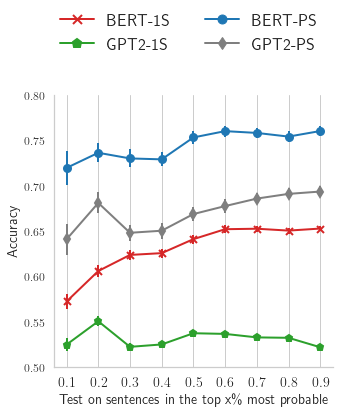

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)

x = perf_prob_ss.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ss.groupby('Mean-prob').mean()['SS-BERT'].to_list()
yerr = 5*perf_prob_ss.groupby('Mean-prob').sem()['SS-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')

x = perf_prob_ss.groupby('Mean-prob').mean().index.to_list()
y_gpt = perf_prob_ss.groupby('Mean-prob').mean()['SS-GPT2'].to_list()
y_gpt = [y_ + 0.007 for y_ in y_gpt]
yerr = 5*perf_prob_ss.groupby('Mean-prob').sem()['SS-GPT2'].to_numpy()
ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:green')


x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ps.groupby('Mean-prob').mean()['Siamese-BERT'].to_list()
yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['Siamese-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:blue')

x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ps.groupby('Mean-prob').mean()['GPT2'].to_list()
yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['GPT2'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.5, 0.80)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks(x)
ax.set_yticks([l/100. for l in range(50, 85, 5)])

ax.set_xlabel('Test on sentences in the top x\% most probable')
ax.set_ylabel('Accuracy')

legend_elem = [
               Line2D([0], [0], marker='x', linewidth=2, ms=9, mew=2, c='tab:red', label='BERT-1S'),
               Line2D([0], [0], marker='p', linewidth=2, ms=9, mew=2, c='tab:green', label='GPT2-1S'),
               Line2D([0], [0], marker='o', linewidth=2, ms=9, c='tab:blue', label='BERT-PS'),
              Line2D([0], [0], marker='d', linewidth=2, ms=9, c='tab:gray', label='GPT2-PS')]

fig.legend(handles=legend_elem, ncol=2, loc='upper center', frameon=False, fontsize=17,  bbox_to_anchor=(0.5, 1.15))

# fig.tight_layout(pad=1.1)
# fig.savefig("performance_prob.pdf", bbox_inches="tight")

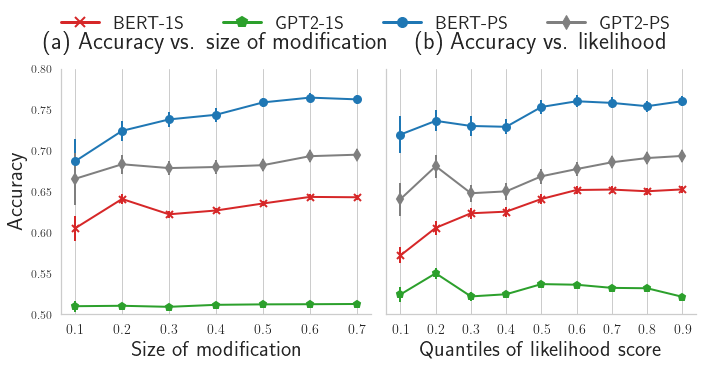

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

csfont = {'fontname':'Times New Roman'}

m = 6

ax = axes[0]
x = perf_size_ss.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ss.groupby('Modification-size (Jaccard)').mean()['SS-BERT'].to_list()
yerr = m*perf_size_ss.groupby('Modification-size (Jaccard)').sem()['SS-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')

x = perf_size_ss.groupby('Modification-size (Jaccard)').mean().index.to_list()
y_gpt = perf_size_ss.groupby('Modification-size (Jaccard)').mean()['SS-GPT2'].to_list()
y_gpt = [y_ + 0.007 for y_ in y_gpt]
yerr = m*perf_size_ss.groupby('Modification-size (Jaccard)').sem()['SS-GPT2'].to_numpy()
ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:green')


x = perf_size_ps.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ps.groupby('Modification-size (Jaccard)').mean()['Siamese-BERT'].to_list()
yerr = m*perf_size_ps.groupby('Modification-size (Jaccard)').sem()['Siamese-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:blue')

x = perf_size_ps.groupby('Modification-size (Jaccard)').mean().index.to_list()
y = perf_size_ps.groupby('Modification-size (Jaccard)').mean()['GPT2'].to_list()
yerr = m*perf_size_ps.groupby('Modification-size (Jaccard)').sem()['GPT2'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.5, 0.80)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks(x)
ax.set_yticks([l/100. for l in range(50, 85, 5)])

ax.set_title('(a) Accuracy vs. size of modification', fontsize=24, pad=20, fontname='Helvetica')
ax.set_xlabel('Size of modification', fontsize=22)
ax.set_ylabel('Accuracy', fontsize=22)

ax = axes[1]
x = perf_prob_ss.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ss.groupby('Mean-prob').mean()['SS-BERT'].to_list()
yerr = m*perf_prob_ss.groupby('Mean-prob').sem()['SS-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')

x = perf_prob_ss.groupby('Mean-prob').mean().index.to_list()
y_gpt = perf_prob_ss.groupby('Mean-prob').mean()['SS-GPT2'].to_list()
y_gpt = [y_ + 0.007 for y_ in y_gpt]
yerr = m*perf_prob_ss.groupby('Mean-prob').sem()['SS-GPT2'].to_numpy()
ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:green')


x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ps.groupby('Mean-prob').mean()['Siamese-BERT'].to_list()
yerr = m*perf_prob_ps.groupby('Mean-prob').sem()['Siamese-BERT'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:blue')

x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
y = perf_prob_ps.groupby('Mean-prob').mean()['GPT2'].to_list()
yerr = m*perf_prob_ps.groupby('Mean-prob').sem()['GPT2'].to_numpy()
ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.5, 0.80)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks(x)
ax.set_yticks([l/100. for l in range(50, 85, 5)])

ax.set_xlabel('Quantiles of likelihood score', fontsize=22)
ax.set_title('(b) Accuracy vs. likelihood', fontsize=24, pad=20)
# ax.set_ylabel('Accuracy')

legend_elem = [
               Line2D([0], [0], marker='x', linewidth=3, ms=10, mew=2, c='tab:red', label='BERT-1S'),
               Line2D([0], [0], marker='p', linewidth=3, ms=10, mew=2, c='tab:green', label='GPT2-1S'),
               Line2D([0], [0], marker='o', linewidth=3, ms=10, c='tab:blue', label='BERT-PS'),
              Line2D([0], [0], marker='d', linewidth=3, ms=10, c='tab:gray', label='GPT2-PS')]

fig.legend(handles=legend_elem, ncol=4, loc='upper center', frameon=False, fontsize=19,  bbox_to_anchor=(0.52, 1.05))

fig.tight_layout(pad=1.1)
# fig.savefig("performance_prob_size.pdf", bbox_inches="tight")

# Attentions

In [27]:
test_df = pd.read_csv('Analysis/test_set_paired.csv')

In [28]:
def load_att_maps(name):
    funny_attentions = []
    funny_attentions_l = np.load(name + '_funny.npz')
    for i in range(len(funny_attentions_l.files)):
        funny_attentions.append(funny_attentions_l['arr_' + str(i)])
    
    serious_attentions = []
    serious_attentions_l = np.load(name + '_serious.npz')
    for i in range(len(serious_attentions_l.files)):
        serious_attentions.append(serious_attentions_l['arr_' + str(i)])
    
    return funny_attentions, serious_attentions

In [32]:
funny_attention_bert_base, serious_attention_bert_base = load_att_maps('Analysis/att_map_BERT_base_full')
funny_attention_bert_ss, serious_attention_bert_ss = load_att_maps('Analysis/att_map_BERT_ss_full')
funny_attention_bert_siamese, serious_attention_bert_siamese = load_att_maps('Analysis/att_map_BERT_siamese_full')

## Finetuning happens in the last layers

In [33]:
from collections import defaultdict
from scipy.spatial import distance
import math

def js_distance_between_heads(head_a, head_b):
    seq_len = head_a.shape[0]
    js_distances = []
    for s in range(seq_len):
        js_d = distance.jensenshannon(head_a[s], head_b[s])
        if math.isnan(js_d):
            continue
        js_distances.append(js_d)
    return np.mean(js_distances)
    
def attention_distance_comparison(att_a, att_b):
    nb_layers = att_a.shape[0]
    nb_heads = att_a.shape[1]
    
    distances = np.zeros((nb_layers, nb_heads))
    for l in range(nb_layers):
        for h in range(nb_heads):
            d_lh = js_distance_between_heads(att_a[l][h], att_b[l][h])
            distances[l][h] = d_lh
    return distances

def attention_distance_over_examples(lst_att_a, lst_att_b):
    att_distances = []
    for att_a, att_b in zip(lst_att_a, lst_att_b):
        if att_a.shape != att_b.shape:
            continue
        att_distances.append(attention_distance_comparison(att_a, att_b))
    return att_distances

# def convert_to_head_distance(att_distances):
#     head_modif = defaultdict(list)
#     head_modif_mat = np.zeros(att_distances[0].shape)
    
#     for x in att_distances:
#         nb_layers = x.shape[0]
#         for i in range(nb_layers):
#             nb_heads = x[i].shape[0]
#             for h in range(nb_heads):
#                 head_modif[str(i)+'-'+str(h)] = x[i][h]                
#                 head_modif_mat[i][h] += x[i][h]
#     head_modif_mat /= len(att_distances)
#     head_diff = {k: np.mean(v) for k, v in head_modif.items()}
#     return pd.DataFrame.from_dict({'head': list(head_diff.keys()), 'distance': list(head_diff.values())}), head_modif_mat

def convert_to_layered_distance(att_distances):
#     layer_modif = defaultdict(list)
    layers, layer_dist = [], []
    for x in att_distances:
        nb_layers = x.shape[0]
        for i in range(nb_layers):
#             layer_modif[i].append(np.mean(x[i]))
            layer_dist.append(np.mean(x[i]))
            layers.append(i)
#     layers_diff = {k: np.mean(v) for k, v in layer_modif.items()}
#     return pd.DataFrame.from_dict({'layer': list(layers_diff.keys()), 'distance': list(layers_diff.values())})
    return pd.DataFrame.from_dict({'layer': layers, 'distance': layer_dist})

In [34]:
attention_bert_base = funny_attention_bert_base.copy()
attention_bert_base.extend(serious_attention_bert_base.copy())

attention_bert_ss = funny_attention_bert_ss.copy()
attention_bert_ss.extend(serious_attention_bert_ss.copy())

attention_bert_siamese = funny_attention_bert_siamese.copy()
attention_bert_siamese.extend(serious_attention_bert_siamese.copy())

att_distance_ss_bert = attention_distance_over_examples(attention_bert_base, attention_bert_ss)
att_distance_siamese_bert = attention_distance_over_examples(attention_bert_base, attention_bert_siamese)

/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:1287: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [35]:
attention_distance_bert_ss_df = convert_to_layered_distance(att_distance_ss_bert)
attention_distance_bert_siamese_df = convert_to_layered_distance(att_distance_siamese_bert)

In [36]:
yerr = 10*attention_distance_bert_siamese_df.groupby('layer').sem()['distance'].to_numpy()

In [153]:
yx = attention_distance_bert_siamese_df[attention_distance_bert_siamese_df['layer'] == 0]['distance']

In [157]:

stats.sem(yx)

4.955716161340839e-05

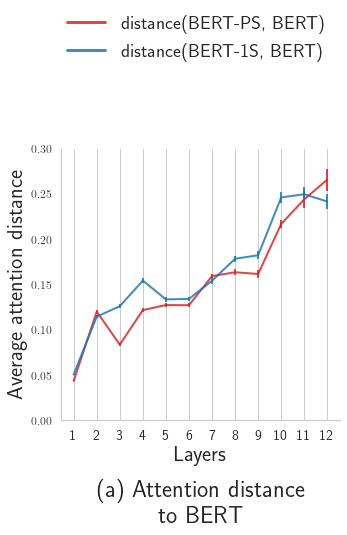

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)

x = attention_distance_bert_siamese_df.groupby('layer').mean().index.to_list()
y = attention_distance_bert_siamese_df.groupby('layer').mean()['distance'].to_list()
yerr = 10*attention_distance_bert_siamese_df.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
ax.errorbar(x,y,yerr, linewidth=2, color='tab:red', alpha=0.85)

x = attention_distance_bert_ss_df.groupby('layer').mean().index.to_list()
y_gpt = attention_distance_bert_ss_df.groupby('layer').mean()['distance'].to_list()
yerr = 10*attention_distance_bert_ss_df.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:blue')
ax.errorbar(x,y_gpt,yerr, linewidth=2, color='tab:blue', alpha=0.85)


# x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
# y = perf_prob_ps.groupby('Mean-prob').mean()['Siamese-BERT'].to_list()
# yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['Siamese-BERT'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:green')

# x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
# y = perf_prob_ps.groupby('Mean-prob').mean()['GPT2'].to_list()
# yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['GPT2'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.0, 0.30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks([int(i) for i in range(12)])
ax.set_yticks([l/100. for l in range(0, 35, 5)])
ax.set_xticklabels([str(i+1) for i in range(12)])
ax.set_xlabel('Layers', fontsize=22)
ax.set_ylabel('Average attention distance', fontsize=22)

ax.set_title('(a) Attention distance \nto BERT', y=-0.4, fontsize=24)

legend_elem = [
               Line2D([0], [0], linewidth=3, c='tab:red', label='distance(BERT-PS, BERT)', alpha=0.85),
               Line2D([0], [0], linewidth=3, c='tab:blue', label='distance(BERT-1S, BERT)', alpha=0.85)
]

fig.legend(handles=legend_elem, ncol=1, loc='upper center', frameon=False, fontsize=19,  bbox_to_anchor=(0.5, 1.3))

# fig.tight_layout(pad=1.13)
# fig.savefig("distance_to_bert.pdf", bbox_inches="tight")

### Difference between funny and serious is in the last layers

In [38]:
funny_serious_att_distance_bert = attention_distance_over_examples(funny_attention_bert_base, serious_attention_bert_base)
funny_serious_att_distance_bert_siamese = attention_distance_over_examples(funny_attention_bert_siamese, serious_attention_bert_siamese)
funny_serious_att_distance_bert_ss = attention_distance_over_examples(funny_attention_bert_ss, serious_attention_bert_ss)

/usr/local/lib/python3.8/site-packages/scipy/spatial/distance.py:1287: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [39]:
funny_serious_att_distance_bert_df = convert_to_layered_distance(funny_serious_att_distance_bert)
funny_serious_att_distance_bert_siamese_df = convert_to_layered_distance(funny_serious_att_distance_bert_siamese)
funny_serious_att_distance_bert_ss_df = convert_to_layered_distance(funny_serious_att_distance_bert_ss)

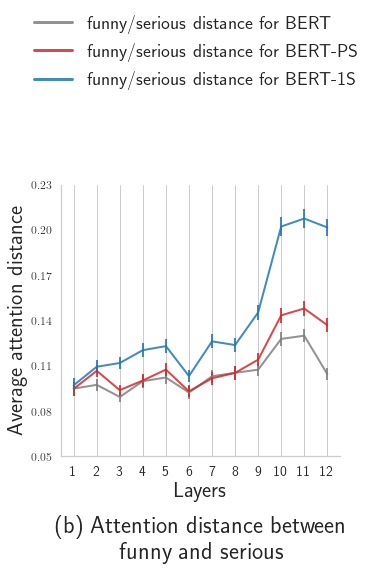

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)

x = funny_serious_att_distance_bert_df.groupby('layer').mean().index.to_list()
y = funny_serious_att_distance_bert_df.groupby('layer').mean()['distance'].to_list()
yerr = 1.96*funny_serious_att_distance_bert_df.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
ax.errorbar(x,y,yerr, linewidth=2, color='tab:gray', alpha=0.85)

x = funny_serious_att_distance_bert_siamese_df.groupby('layer').mean().index.to_list()
y_gpt = funny_serious_att_distance_bert_siamese_df.groupby('layer').mean()['distance'].to_list()
yerr = 1.96*funny_serious_att_distance_bert_siamese_df.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:blue')
ax.errorbar(x,y_gpt,yerr, linewidth=2, color='tab:red', alpha=0.85)


x = funny_serious_att_distance_bert_ss_df.groupby('layer').mean().index.to_list()
y_gpt = funny_serious_att_distance_bert_ss_df.groupby('layer').mean()['distance'].to_list()
yerr = 1.96*funny_serious_att_distance_bert_ss_df.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:blue')
ax.errorbar(x,y_gpt,yerr, linewidth=2, color='tab:blue', alpha=0.85)

# x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
# y = perf_prob_ps.groupby('Mean-prob').mean()['Siamese-BERT'].to_list()
# yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['Siamese-BERT'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-o', mew=2, ms=7, color='tab:green')

# x = perf_prob_ps.groupby('Mean-prob').mean().index.to_list()
# y = perf_prob_ps.groupby('Mean-prob').mean()['GPT2'].to_list()
# yerr = 5*perf_prob_ps.groupby('Mean-prob').sem()['GPT2'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-d', mew=2, ms=7, color='tab:gray')

ax.set_ylim(0.05, 0.23)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks([int(i) for i in range(12)])
ax.set_xticklabels([str(i+1) for i in range(12)])
ax.set_yticks([l/100. for l in range(5, 25, 3)])

ax.set_xlabel('Layers', fontsize=22)
ax.set_ylabel('Average attention distance', fontsize=22)

ax.set_title('(b) Attention distance between \n funny and serious', y=-0.4, fontsize=24)

legend_elem = [
               Line2D([0], [0], linewidth=3, c='tab:gray', label='funny/serious distance for BERT', alpha=0.85),
               Line2D([0], [0], linewidth=3, c='tab:red', label='funny/serious distance for BERT-PS', alpha=0.85),
               Line2D([0], [0], linewidth=3, c='tab:blue', label='funny/serious distance for BERT-1S', alpha=0.85)
]

fig.legend(handles=legend_elem, ncol=1, loc='upper center', frameon=False, fontsize=19,  bbox_to_anchor=(0.50, 1.4))

# fig.tight_layout(pad=1.)
# fig.savefig("funny_serious_distance.pdf", bbox_inches="tight")

### Entropy variations with depth

In [160]:
def entropy_heads(head):
    seq_len = head.shape[0]
    entropies = []
    for s in range(seq_len):
        h = stats.entropy(head[s])
        if math.isnan(h):
            continue
        entropies.append(h)
    return np.mean(entropies)
    
def attention_entropy(att):
    nb_layers = att.shape[0]
    nb_heads = att.shape[1]
    
    entropies = np.zeros((nb_layers, nb_heads))
    for l in range(nb_layers):
        for h in range(nb_heads):
            d_lh = entropy_heads(att[l][h])
            entropies[l][h] = d_lh
    return entropies

def attention_entropy_over_examples(lst_att):
    att_entropies = []
    for att in lst_att:
        att_entropies.append(attention_entropy(att))
    return att_entropies

In [161]:
att_entropies_base_funny = convert_to_layered_distance(attention_entropy_over_examples(funny_attention_bert_base))
att_entropies_ss_funny = convert_to_layered_distance(attention_entropy_over_examples(funny_attention_bert_ss))
att_entropies_siamese_funny = convert_to_layered_distance(attention_entropy_over_examples(funny_attention_bert_siamese))

att_entropies_base_serious = convert_to_layered_distance(attention_entropy_over_examples(serious_attention_bert_base))
att_entropies_ss_serious = convert_to_layered_distance(attention_entropy_over_examples(serious_attention_bert_ss))
att_entropies_siamese_serious = convert_to_layered_distance(attention_entropy_over_examples(serious_attention_bert_siamese))

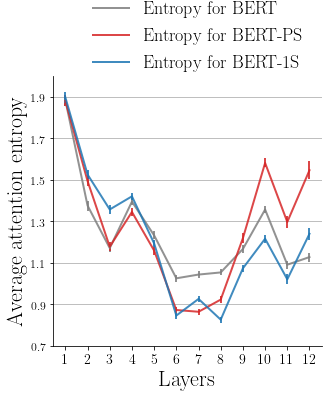

In [497]:
base_entropies = att_entropies_base_funny
ss_entropies = att_entropies_ss_funny
siamese_entropies = att_entropies_siamese_funny

# base_entropies = att_entropies_base_serious
# ss_entropies = att_entropies_ss_serious
# siamese_entropies = att_entropies_siamese_serious

fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax = sns.lineplot(data=perf_size_ps, x='Modification-size (Jaccard)', y='Siamese-BERT', ax=ax)

x = base_entropies.groupby('layer').mean().index.to_list()
y = base_entropies.groupby('layer').mean()['distance'].to_list()
yerr = 4.96*base_entropies.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
ax.errorbar(x,y,yerr, linewidth=2, color='tab:gray', alpha=0.85)

x = siamese_entropies.groupby('layer').mean().index.to_list()
y_gpt = siamese_entropies.groupby('layer').mean()['distance'].to_list()
yerr = 4.96*siamese_entropies.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:blue')
ax.errorbar(x,y_gpt,yerr, linewidth=2, color='tab:red', alpha=0.85)


x = ss_entropies.groupby('layer').mean().index.to_list()
y_gpt = ss_entropies.groupby('layer').mean()['distance'].to_list()
yerr = 4.96*ss_entropies.groupby('layer').sem()['distance'].to_numpy()
# ax.errorbar(x,y_gpt,yerr, elinewidth=2, linewidth=2, fmt='-p', mew=2, ms=7, color='tab:blue')
ax.errorbar(x,y_gpt,yerr, linewidth=2, color='tab:blue', alpha=0.85)

ax.set_ylim(0.7, 2.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
ax.set_xticks([int(i) for i in range(12)])
ax.set_xticklabels([str(i+1) for i in range(12)])
ax.set_yticks([l/10. for l in range(7, 20, 2)])

ax.set_xlabel('Layers', fontsize=22)
ax.set_ylabel('Average attention entropy', fontsize=22)

legend_elem = [
               Line2D([0], [0], linewidth=2, c='tab:gray', label='Entropy for BERT', alpha=0.85),
               Line2D([0], [0], linewidth=2, c='tab:red', label='Entropy for BERT-PS', alpha=0.85),
               Line2D([0], [0], linewidth=2, c='tab:blue', label='Entropy for BERT-1S', alpha=0.85)
]

fig.legend(handles=legend_elem, ncol=1, loc='upper center', frameon=False, fontsize=18,  bbox_to_anchor=(0.55, 1.15))

fig.tight_layout(pad=1.5)
fig.savefig("entropy.pdf", bbox_inches="tight")

In [332]:
x= ['a', 'b', 'c']
x[-2]

'b'

## Attention Paid to first and last words

In [41]:
def attention_pos_head(head):
    seq_len = head.shape[0]
    special_pos = [1, -2]
    attentions_on_first = []
    attentions_on_last = []
    attentions_on_other = []
    attentions_on_spec_tok = []
    for s in range(seq_len):
        try:
            att_first = head[s][1]
            att_last = head[s][-2]
            att_other = np.sum([head[s][p] for p in range(2, seq_len-2)]) / (len(range(2, seq_len-2)))
            att_spe_tok = (head[s][0] + head[s][-1]) / 2.
#             if math.isnan(att_res) or math.isinf(att_res):
#                 continue
#             print(att_rest)
        except:
            print('here')
            continue
        
        attentions_on_first.append(att_first)
        attentions_on_last.append(att_last)
        attentions_on_other.append(att_other)
        attentions_on_spec_tok.append(att_spe_tok)
#         attention_on_cls.append(att_cls)
    return np.mean(attentions_on_first), np.mean(attentions_on_last), np.mean(attentions_on_other), np.mean(attentions_on_spec_tok)

def attention_pos(att):
    nb_layers = att.shape[0]
    nb_heads = att.shape[1]
    
    attentions_on_first = np.zeros((nb_layers, nb_heads))
    attentions_on_last = np.zeros((nb_layers, nb_heads))
    attentions_on_other = np.zeros((nb_layers, nb_heads))
    attentions_on_spe = np.zeros((nb_layers, nb_heads))
    for l in range(nb_layers):
        for h in range(nb_heads):
            f, l_, o, sp = attention_pos_head(att[l][h])
            attentions_on_first[l][h] = f
            attentions_on_last[l][h] = l_
            attentions_on_other[l][h] = o
            attentions_on_spe[l][h] = sp
    return attentions_on_first, attentions_on_last, attentions_on_other, attentions_on_spe

def attention_pos_examples(lst_att):
    attentions_on_first = []
    attentions_on_last = []
    attentions_on_other = []
    attentions_on_spe = []
    for att in lst_att:
        f, l, o, sp = attention_pos(att)
        attentions_on_first.append(f)
        attentions_on_last.append(l)
        attentions_on_other.append(o)
        attentions_on_spe.append(sp)
    return attentions_on_first, attentions_on_last, attentions_on_other, attentions_on_spe

In [42]:
bert_pos_att = attention_pos_examples(funny_attention_bert_base)
ss_pos_att = attention_pos_examples(funny_attention_bert_ss)
siamese_pos_att = attention_pos_examples(funny_attention_bert_siamese)

<ipython-input-45-9b19dc6c323f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('', '' , 'On first', '', 'On last', '', 'On others'), fontsize=22)
<ipython-input-45-9b19dc6c323f>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('', '' , 'On [SEP] \& [CLS]'), fontsize=22)
<ipython-input-45-9b19dc6c323f>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.1)


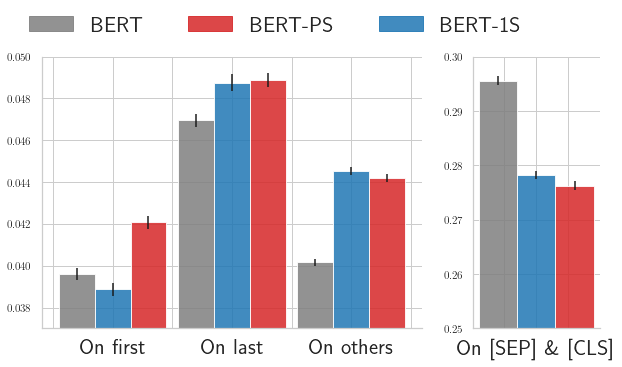

In [45]:
grid_kws = {"width_ratios": (.75, .25), "hspace": .2}
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=grid_kws)

ax =axes[0]
x_label = ['On first', 'On last', 'On others', "On ``[SEP]'' and ``[CLS]''"]
w = 0.3 

x = np.array([0, 1, 2])
ys = [np.mean(bert_pos_x) for bert_pos_x in bert_pos_att[:3]]
yerr = [3.96*stats.sem(np.array(bert_pos_x).flatten()) for bert_pos_x in bert_pos_att[:3]]

ax.bar(x-w, ys, width=w, yerr=yerr, color='tab:gray', alpha=0.85)

# x = ['On first', 'On Last', 'On other']
ys = [np.mean(bert_pos_x) for bert_pos_x in ss_pos_att[:3]]
yerr = [3.96*stats.sem(np.array(bert_pos_x).flatten()) for bert_pos_x in ss_pos_att[:3]]

ax.bar(x, ys, width=w, yerr=yerr, color='tab:blue', alpha=0.85)

ys = [np.mean(bert_pos_x) for bert_pos_x in siamese_pos_att[:3]]
yerr = [3.96*stats.sem(np.array(bert_pos_x).flatten()) for bert_pos_x in siamese_pos_att[:3]]

ax.bar(x+w, ys, width=w, yerr=yerr, color='tab:red', alpha=0.85)

ax.set_ylim(0.037, .05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticklabels(('', '' , 'On first', '', 'On last', '', 'On others'), fontsize=22)

ax = axes[1]
x = np.array([0])
ys = [np.mean(bert_pos_att[3])]
yerr = [3.96*stats.sem(np.array(bert_pos_att[3]).flatten()) ]

ax.bar(x-w, ys, width=w, yerr=yerr, color='tab:gray', alpha=0.85)

# x = ['On first', 'On Last', 'On other']
ys = [np.mean(ss_pos_att[3])]
yerr = [3.96*stats.sem(np.array(ss_pos_att[3]).flatten())]

ax.bar(x, ys, width=w, yerr=yerr, color='tab:blue', alpha=0.85)

ys = [np.mean(siamese_pos_att[3])]
yerr = [3.96*stats.sem(np.array(siamese_pos_att[3]).flatten())]

ax.bar(x+w, ys, width=w, yerr=yerr, color='tab:red', alpha=0.85)

ax.set_ylim(0.25, .30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticklabels(('', '' , 'On [SEP] \& [CLS]'), fontsize=22)
      
legend_elem = [
               mpatches.Patch(color='tab:gray', label='BERT', alpha=0.85),
               mpatches.Patch(color='tab:red', label='BERT-PS', alpha=0.85),
               mpatches.Patch(color='tab:blue', label='BERT-1S', alpha=0.85)
]

fig.legend(handles=legend_elem, ncol=3, loc='upper center', frameon=False, fontsize=22,  bbox_to_anchor=(0.45, 1.05))
fig.tight_layout(pad=1.1)
# fig.savefig("att_pos.pdf", bbox_inches="tight")

<ipython-input-46-3aef85188757>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i+1) for i in range(12)])
<ipython-input-46-3aef85188757>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i+1) for i in range(12)])


[Text(0, 0.25, '1'),
 Text(0, 0.26, '2'),
 Text(0, 0.27, '3'),
 Text(0, 0.27999999999999997, '4'),
 Text(0, 0.29, '5'),
 Text(0, 0.3, '6')]

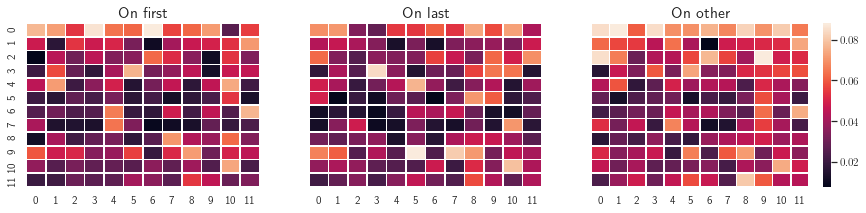

In [46]:
to_plot = ss_pos_att

on_first, on_last, on_others, _ = to_plot


grid_kws = {"width_ratios": (.30, .30, .35), "hspace": .2}
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True, gridspec_kw=grid_kws)
# fig, axes = plt.subplots(1, 1)
sns.heatmap(np.mean(np.array(on_first), axis=0), cbar=False, linewidth=0.5, ax=axes[0])
axes[0].set_title('On first', fontsize=16)
sns.heatmap(np.mean(np.array(on_last), axis=0), cbar=False, linewidth=0.5, ax=axes[1])
axes[1].set_title('On last', fontsize=16)
sns.heatmap(np.mean(np.array(on_others), axis=0), linewidth=0.5,  ax=axes[2])
axes[2].set_title('On other', fontsize=16)

ax.set_xticklabels([str(i+1) for i in range(12)])
ax.set_yticklabels([str(i+1) for i in range(12)])
# fig.tight_layout(pad=1.1)
# fig.savefig("bert_ss_siamese_funny_serious.pdf", bbox_inches="tight")

# Head 9-5

In [47]:
def attention_mod_head(head, mod_pos):
    seq_len = head.shape[0]
    attention_on_chunk = []
    attention_on_rest = []
    attention_on_sep = []
    attention_on_cls = []
    for s in range(seq_len):
        try:
            att_cls = head[s][0]
            att_sep = head[s][-1]
            att_chunk = np.sum([head[s][p] for p in mod_pos]) / len(mod_pos)
            att_rest = (1 - att_chunk - att_cls - att_sep)/ (seq_len - 2 - len(mod_pos))
#             if math.isnan(att_res) or math.isinf(att_res):
#                 continue
#             print(att_rest)
        except:
            print('here')
            continue
        
        attention_on_chunk.append(att_chunk)
        attention_on_rest.append(att_rest)
        attention_on_sep.append(att_sep)
        attention_on_cls.append(att_cls)
    return np.mean(attention_on_chunk), np.mean(attention_on_rest), np.mean(attention_on_cls), np.mean(attention_on_sep)

def attention_mod(att, mod_pos):
    nb_layers = att.shape[0]
    nb_heads = att.shape[1]
    
    attentions_on_chunk = np.zeros((nb_layers, nb_heads))
    attentions_on_rest = np.zeros((nb_layers, nb_heads))
    attentions_on_sep = np.zeros((nb_layers, nb_heads))
    attentions_on_cls = np.zeros((nb_layers, nb_heads))
    for l in range(nb_layers):
        for h in range(nb_heads):
            c, r, s, cls = attention_mod_head(att[l][h], mod_pos)
            attentions_on_chunk[l][h] = c
            attentions_on_rest[l][h] = r
            attentions_on_sep[l][h] = s
            attentions_on_cls[l][h] = cls
    return attentions_on_chunk, attentions_on_rest, attentions_on_sep, attentions_on_cls

def attention_mod_over_examples(lst_att, lst_mod_pos):
    attentions_on_chunk = []
    attentions_on_rest = []
    attentions_on_sep = []
    attentions_on_cls = []
    for att, mod_pos in zip(lst_att, lst_mod_pos):
        c, r, s, cls = attention_mod(att, mod_pos)
        attentions_on_chunk.append(c)
        attentions_on_rest.append(r)
        attentions_on_sep.append(s)
        attentions_on_cls.append(cls)
    return attentions_on_chunk, attentions_on_rest, attentions_on_sep, attentions_on_cls

In [48]:
def attention_to_list_with_mod_pos(lst_funny_att, lst_serious_att, test_df):
    lst_mod_pos = []
    lst_reduced_funny_att, lst_reduced_serious_att = [], []
    for i in range(test_df.shape[0]):
        row = test_df.iloc[i]
        funny = row['headline_original'].split(' ')
        serious = row['headline_unfunned'].split(' ')
        
        if len(funny) != len(serious):
            continue
        
        if len(funny) < 3:
            continue
        
        if len(set(funny).symmetric_difference(set(serious))) > 2:
            continue
            
        mod_pos = []
        for j in range(len(funny)):
            if funny[j] != serious[j]:
                mod_pos.append(j+1) # Account for the initial token
        
        if len(mod_pos) == 0 or len(mod_pos) > 2:
            continue
        
        lst_mod_pos.append(mod_pos)
        lst_reduced_funny_att.append(lst_funny_att[i])
        lst_reduced_serious_att.append(lst_serious_att[i]) 
    
    return attention_mod_over_examples(lst_reduced_funny_att, lst_mod_pos), attention_mod_over_examples(lst_reduced_serious_att, lst_mod_pos)

In [49]:
funny_attention_base_pos, serious_attention_base_pos = attention_to_list_with_mod_pos(funny_attention_bert_base, serious_attention_bert_base, test_df)
funny_attention_ss_pos, serious_attention_ss_pos = attention_to_list_with_mod_pos(funny_attention_bert_ss, serious_attention_bert_ss, test_df)
funny_attention_siamese_pos, serious_attention_siamese_pos = attention_to_list_with_mod_pos(funny_attention_bert_siamese, serious_attention_bert_siamese, test_df)

<ipython-input-53-25de51cd8827>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


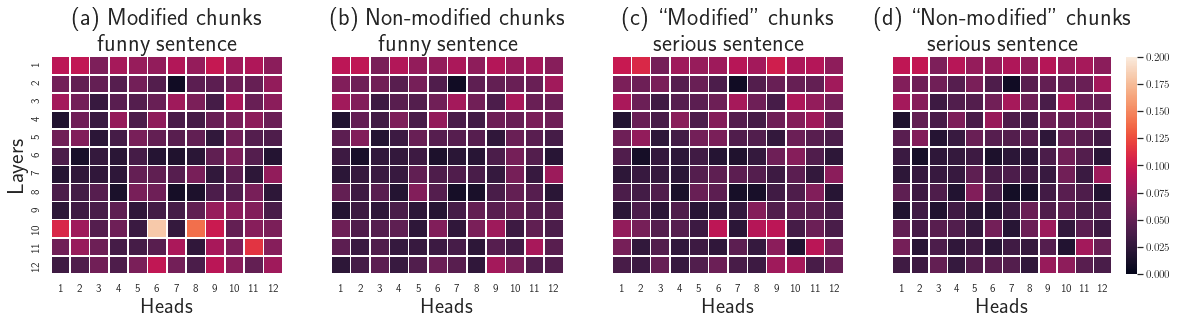

In [53]:
mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos
mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos
# mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

# mod_funny, non_mod_funny, _, _ = funny_attention_base_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_base_pos
vmin=0.0
vmax=0.2

grid_kws = {"width_ratios": (.22, .22, .22, .26), "hspace": .2}
fig, axes = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw=grid_kws, sharex=True, sharey=True)
sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('(a) Modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('(b) Non-modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, ax=axes[2], vmin=vmin, vmax=vmax)
axes[2].set_title('(c) ``Modified" chunks\nserious sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5, ax=axes[3], vmin=vmin, vmax=vmax)
axes[3].set_title('(d) ``Non-modified" chunks\nserious sentence', fontsize=24)

axes[0].set_yticklabels([str(i+1) for i in range(12)])
axes[0].set_ylabel('Layers', fontsize=23)
[axes[i].set_xlabel('Heads', fontsize=22) for i in range(4)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

fig.tight_layout(pad=1)
# fig.savefig("ss_mod.pdf", bbox_inches="tight")

<ipython-input-55-5936eadf9e44>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


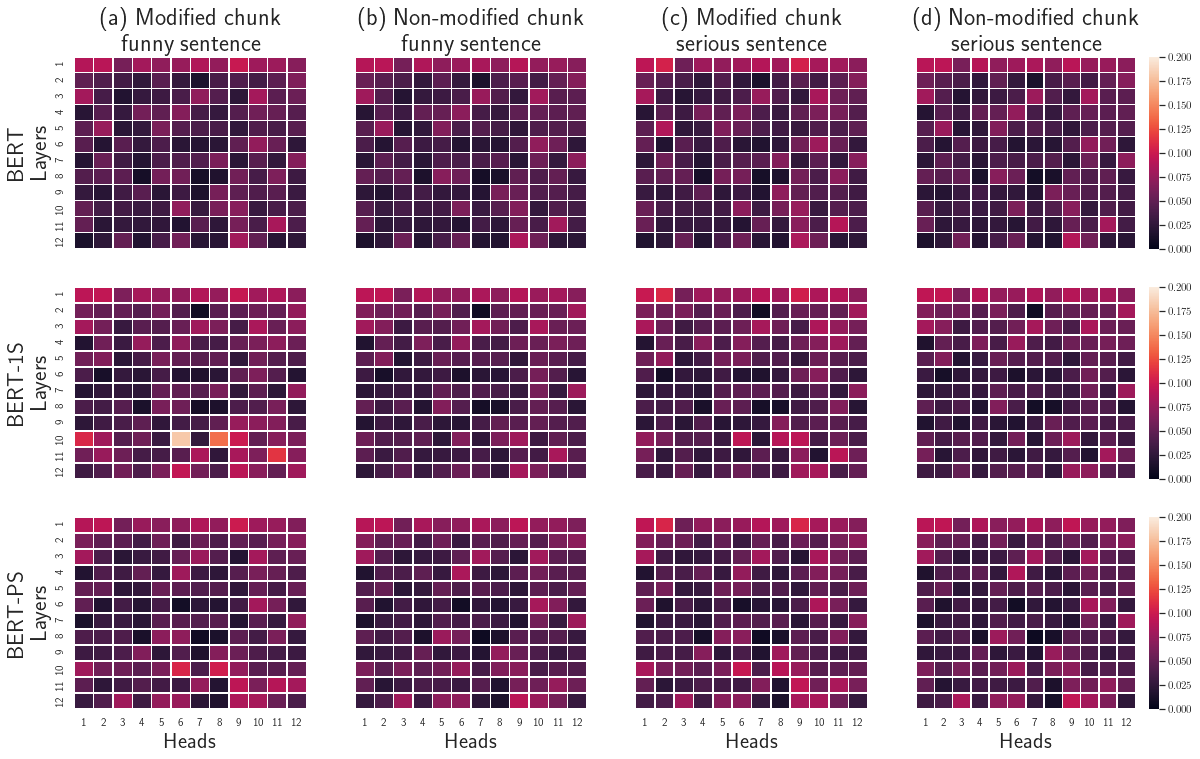

In [55]:
grid_kws = {"width_ratios": (.22, .22, .22, .26), "hspace": .2}
fig, axes = plt.subplots(3, 4, figsize=(20, 12), gridspec_kw=grid_kws, sharex=True, sharey=True)

# mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos
# mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

mod_funny, non_mod_funny, _, _ = funny_attention_base_pos
mod_serious, non_mod_serious, _, _ = serious_attention_base_pos

sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[0][0])
# axes[0].set_title('Average attention on chunk \n for funny for BERT-1S', fontsize=14)
axes[0][0].set_title('(a) Modified chunk\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[0][1])
axes[0][1].set_title('(b) Non-modified chunk\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[0][2])
axes[0][2].set_title('(c) Modified chunk\nserious sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[0][3])
axes[0][3].set_title('(d) Non-modified chunk\nserious sentence', fontsize=24)

axes[0][0].set_yticklabels([str(i+1) for i in range(12)])
axes[0][0].set_ylabel('BERT \n Layers', fontsize=23)
[axes[0][i].set_xlabel('', fontsize=22) for i in range(4)]
a = [axes[0][i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]


mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos
mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos

sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[1][0])
# axes[0].set_title('Average attention on chunk \n for funny for BERT-1S', fontsize=14)
# axes[1][0].set_title('a) Modified chunk\nfunny sentence', fontsize=22)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[1][1])
# axes[1][1].set_title('b) non-modified chunk\nfunny sentence', fontsize=22)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[1][2])
# axes[1][2].set_title('c) modified chunk\nserious sentence', fontsize=22)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[1][3])
# axes[1][3].set_title('d) non-modified chunk\nserious sentence', fontsize=22)

axes[1][0].set_yticklabels([str(i+1) for i in range(12)])
axes[1][0].set_ylabel('BERT-1S \n Layers', fontsize=23)
[axes[1][i].set_xlabel('', fontsize=22) for i in range(4)]
a = [axes[1][i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[2][0])
# axes[0].set_title('Average attention on chunk \n for funny for BERT-1S', fontsize=14)
# axes[2][0].set_title('a) Modified chunk\nfunny sentence', fontsize=22)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[2][1])
# axes[2][1].set_title('b) non-modified chunk\nfunny sentence', fontsize=22)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[2][2])
# axes[2][2].set_title('c) modified chunk\nserious sentence', fontsize=22)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5, vmin=0.0, vmax=0.2, ax=axes[2][3])
# axes[2][3].set_title('d) non-modified chunk\nserious sentence', fontsize=22)

axes[2][0].set_yticklabels([str(i+1) for i in range(12)])
axes[2][0].set_ylabel('BERT-PS \n Layers', fontsize=23)
[axes[2][i].set_xlabel('Heads', fontsize=22) for i in range(4)]
a = [axes[2][i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

fig.tight_layout(pad=1)
# fig.savefig("mod_appendix.pdf", bbox_inches="tight")

<ipython-input-56-54a04d4a7551>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.1)


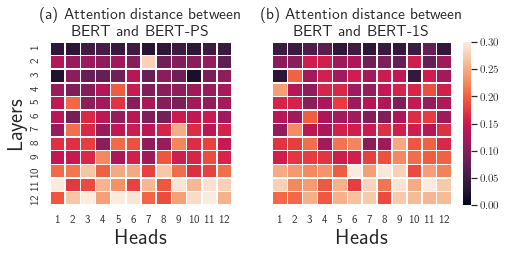

In [56]:
grid_kws = {"width_ratios": (.44, .54), "hspace": .2}
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True, gridspec_kw=grid_kws)
# fig, axes = plt.subplots(1, 1)
sns.heatmap(np.mean(np.array(att_distance_siamese_bert), axis=0), linewidth=0.5, cbar=False,vmin=0.0, vmax=0.3, ax=axes[0])
axes[0].set_title('(a) Attention distance between\n BERT and BERT-PS', fontsize=16)
sns.heatmap(np.mean(np.array(att_distance_ss_bert), axis=0), linewidth=0.5,vmin=0.0, vmax=0.3, ax=axes[1])
axes[1].set_title('(b) Attention distance between\n BERT and BERT-1S', fontsize=16)

axes[0].set_yticklabels([str(i+1) for i in range(12)])
axes[0].set_ylabel('Layers', fontsize=22)
[axes[i].set_xlabel('Heads', fontsize=22) for i in range(2)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(2)]

fig.tight_layout(pad=1.1)
# fig.savefig("bert_ss_siamese_att_distance.pdf", bbox_inches="tight")

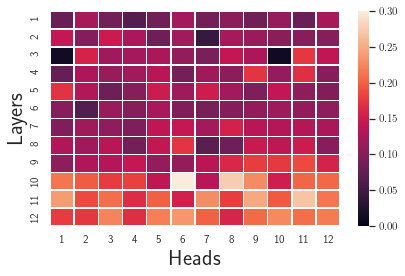

In [57]:
grid_kws = {"width_ratios": (.30, .30, .35), "hspace": .2}
# fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True, gridspec_kw=grid_kws)
fig, ax = plt.subplots(1, 1)

sns.heatmap(np.mean(np.array(funny_serious_att_distance_bert_ss), axis=0), linewidth=0.5,vmin=0.0, vmax=0.3, ax=ax)

ax.set_yticklabels([str(i+1) for i in range(12)])
ax.set_ylabel('Layers', fontsize=22)
ax.set_xlabel('Heads', fontsize=22)
ax.set_xticklabels([str(i+1) for i in range(12)])

fig.tight_layout(pad=1.1)
# fig.savefig("bert_ss_funny_serious.pdf", bbox_inches="tight")

In [58]:
for i in range(12):
    print(np.sum(np.mean(np.array(funny_serious_att_distance_bert_ss), axis=0)[9][i] / np.sum(np.mean(np.array(funny_serious_att_distance_bert_ss), axis=0)[9])))

0.08798374376656502
0.08122996138370851
0.07329207462349432
0.07420207152252047
0.058404006319158916
0.12931570419776922
0.05603668350478014
0.11351793262316671
0.0940417503652133
0.0635361450544318
0.0839427259402339
0.08449720069895747


<ipython-input-60-36703fbadf84>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.1)


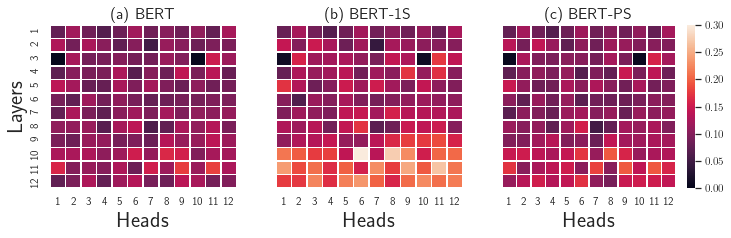

In [60]:
grid_kws = {"width_ratios": (.30, .30, .35), "hspace": .2}
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True, gridspec_kw=grid_kws)
# fig, axes = plt.subplots(1, 1)
sns.heatmap(np.mean(np.array(funny_serious_att_distance_bert), axis=0), linewidth=0.5, cbar=False,vmin=0.0, vmax=0.3, ax=axes[0])
axes[0].set_title('(a) BERT', fontsize=16)
sns.heatmap(np.mean(np.array(funny_serious_att_distance_bert_ss), axis=0), linewidth=0.5,vmin=0.0, cbar=False, vmax=0.3, ax=axes[1])
axes[1].set_title('(b) BERT-1S', fontsize=16)
sns.heatmap(np.mean(np.array(funny_serious_att_distance_bert_siamese), axis=0), linewidth=0.5,vmin=0.0, vmax=0.3, ax=axes[2])
axes[2].set_title('(c) BERT-PS', fontsize=16)

axes[0].set_yticklabels([str(i+1) for i in range(12)])
axes[0].set_ylabel('Layers', fontsize=22)
[axes[i].set_xlabel('Heads', fontsize=22) for i in range(3)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(3)]

fig.tight_layout(pad=1.1)
# fig.savefig("bert_ss_siamese_funny_serious.pdf", bbox_inches="tight")